<a href="https://colab.research.google.com/github/Camouflage10/disease-spread-model/blob/main/disease_model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
#comment out pips when uploading
!pip install ruamel.yaml

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 109 kB 6.5 MB/s 
     |████████████████████████████████| 546 kB 42.0 MB/s 


In [2]:
import numpy as np
from tensorflow import keras
from keras.models import Sequential
from keras.layers import Dense, LSTM, Dropout, Conv2D, MaxPooling2D, Flatten
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.metrics import confusion_matrix, recall_score, precision_score
import seaborn as sn
from ruamel.yaml import YAML
import json

In [3]:
def load_params():
    "Updates FULL_PARAMS with the values in params.yaml and returns all as a dictionary"
    yaml = YAML(typ="safe")
    with open("params.yaml") as f:
        params = yaml.load(f)
    return params

In [4]:
from matplotlib import text
x = pd.read_csv ('dengue_features_train.csv')
y = pd.read_csv('dengue_labels_train.csv')
test =pd.read_csv ('dengue_features_test.csv')


In [5]:
x

,city,year,weekofyear,week_start_date,ndvi_ne,ndvi_nw,ndvi_se,ndvi_sw,precipitation_amt_mm,reanalysis_air_temp_k,...,reanalysis_precip_amt_kg_per_m2,reanalysis_relative_humidity_percent,reanalysis_sat_precip_amt_mm,reanalysis_specific_humidity_g_per_kg,reanalysis_tdtr_k,station_avg_temp_c,station_diur_temp_rng_c,station_max_temp_c,station_min_temp_c,station_precip_mm
0,sj,1990,18,1990-04-30,0.122600,0.103725,0.198483,0.177617,12.42,297.572857,...,32.00,73.365714,12.42,14.012857,2.628571,25.442857,6.900000,29.4,20.0,16.0
1,sj,1990,19,1990-05-07,0.169900,0.142175,0.162357,0.155486,22.82,298.211429,...,17.94,77.368571,22.82,15.372857,2.371429,26.714286,6.371429,31.7,22.2,8.6
2,sj,1990,20,1990-05-14,0.032250,0.172967,0.157200,0.170843,34.54,298.781429,...,26.10,82.052857,34.54,16.848571,2.300000,26.714286,6.485714,32.2,22.8,41.4
3,sj,1990,21,1990-05-21,0.128633,0.245067,0.227557,0.235886,15.36,298.987143,...,13.90,80.337143,15.36,16.672857,2.428571,27.471429,6.771429,33.3,23.3,4.0
4,sj,1990,22,1990-05-28,0.196200,0.262200,0.251200,0.247340,7.52,299.518571,...,12.20,80.460000,7.52,17.210000,3.014286,28.942857,9.371429,35.0,23.9,5.8
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1451,iq,2010,21,2010-05-28,0.342750,0.318900,0.256343,0.292514,55.30,299.334286,...,45.00,88.765714,55.30,18.485714,9.800000,28.633333,11.933333,35.4,22.4,27.0
1452,iq,2010,22,2010-06-04,0.160157,0.160371,0.136043,0.225657,86.47,298.330000,...,207.10,91.600000,86.47,18.070000,7.471429,27.433333,10.500000,34.7,21.7,36.6
1453,iq,2010,23,2010-06-11,0.247057,0.146057,0.250357,0.233714,58.94,296.598571,...,50.60,94.280000,58.94,17.008571,7.500000,24.400000,6.900000,32.2,19.2,7.4
1454,iq,2010,24,2010-06-18,0.333914,0.245771,0.278886,0.325486,59.67,296.345714,...,62.33,94.660000,59.67,16.815714,7.871429,25.433333,8.733333,31.2,21.0,16.0


In [6]:
y

,city,year,weekofyear,total_cases
0,sj,1990,18,4
1,sj,1990,19,5
2,sj,1990,20,4
3,sj,1990,21,3
4,sj,1990,22,6
...,...,...,...,...
1451,iq,2010,21,5
1452,iq,2010,22,8
1453,iq,2010,23,1
1454,iq,2010,24,1


In [7]:
test=test.drop(columns=['city', 'year', 'week_start_date'])
y=y.drop(columns=['city', 'year'])
x=x.drop(columns=['city', 'year', 'week_start_date'])


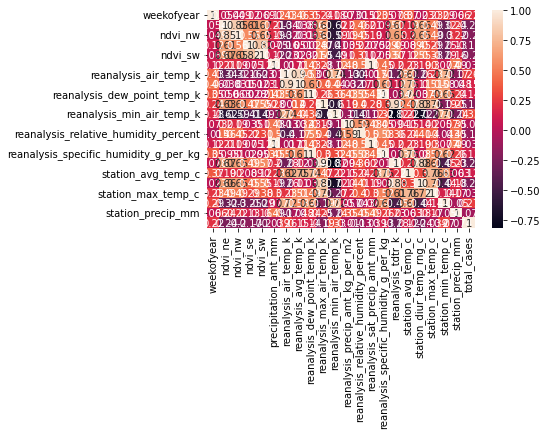

weekofyear                               0.216452
ndvi_ne                                 -0.241376
ndvi_nw                                 -0.202235
ndvi_se                                 -0.168612
ndvi_sw                                 -0.196461
precipitation_amt_mm                    -0.038740
reanalysis_air_temp_k                    0.264952
reanalysis_avg_temp_k                    0.151637
reanalysis_dew_point_temp_k              0.142531
reanalysis_max_air_temp_k               -0.191345
reanalysis_min_air_temp_k                0.325252
reanalysis_precip_amt_kg_per_m2         -0.010031
reanalysis_relative_humidity_percent    -0.132452
reanalysis_sat_precip_amt_mm            -0.038740
reanalysis_specific_humidity_g_per_kg    0.129861
reanalysis_tdtr_k                       -0.278483
station_avg_temp_c                       0.116109
station_diur_temp_rng_c                 -0.237844
station_max_temp_c                      -0.039219
station_min_temp_c                       0.267109


In [8]:
#data analysis

x['total_cases']=y['total_cases']
corrMatrix = x.corr()
sn.heatmap(corrMatrix, annot=True)
plt.show()
lastCol=corrMatrix.iloc[:,-1]
print(lastCol)

In [9]:
#remove NaN
x['total_cases']=y['total_cases']
x=x.dropna()
test=test.dropna()
y=x['total_cases']
x=x.drop(columns=['total_cases'])
#preprocessing-train test split
from sklearn.model_selection import train_test_split
#x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.33)

In [10]:
#model
#define model
def DNN_model(inputShape=(x.shape[1],1)):
  model=Sequential()
  #input
  model.add(Dense(200, input_shape=inputShape))
  #hidden layer
  model.add(Dense(100))
  model.add(Dense(50))
  model.add(Dense(25))
  model.add(Dense(10))
  #model.add(Dropout())
  model.add(Flatten())
  #output
  model.add(Dense(1))
  #compile model
  model.compile(optimizer='adam', loss='mean_squared_error')
  return model

In [18]:
def tunable_model(inputShape=(x.shape[1],1)):
  model=Sequential()
  #input
  model.add(Dense(128, input_shape=inputShape))
  #hidden layer
  model.add(Dense(64))
  model.add(Dense(20))
  model.add(Flatten())
  #output
  model.add(Dense(1))
  #compile model
  model.compile(optimizer='adam', loss='mean_squared_error')
  return model

In [19]:
#tuning
x.isnull().values.sum()

0

In [20]:
#training
#ints to float
#test = np.asarray(test).astype('float32')
#x_train = np.asarray(x_train).astype('float32')
#y_train = np.asarray(y_train).astype('float32')
model=DNN_model()
history=model.fit(x,y,epochs=20, validation_split=.1)

Epoch 1/20
34/34 [==============================] - 1s 15ms/step - loss: 1222.1045 - val_loss: 339.5514
Epoch 2/20
34/34 [==============================] - 0s 8ms/step - loss: 1029.4667 - val_loss: 201.8235
Epoch 3/20
34/34 [==============================] - 0s 7ms/step - loss: 1033.5702 - val_loss: 192.9880
Epoch 4/20
34/34 [==============================] - 0s 8ms/step - loss: 1057.3833 - val_loss: 404.8365
Epoch 5/20
34/34 [==============================] - 0s 7ms/step - loss: 1002.6989 - val_loss: 559.3641
Epoch 6/20
34/34 [==============================] - 0s 9ms/step - loss: 997.6949 - val_loss: 338.9132
Epoch 7/20
34/34 [==============================] - 0s 8ms/step - loss: 974.6553 - val_loss: 432.8108
Epoch 8/20
34/34 [==============================] - 0s 8ms/step - loss: 934.1646 - val_loss: 263.7551
Epoch 9/20
34/34 [==============================] - 0s 8ms/step - loss: 935.2240 - val_loss: 359.1520
Epoch 10/20
34/34 [==============================] - 0s 7ms/step - loss: 944

In [21]:

#loss

#rmse

#other metrics

In [14]:
#create metrics.json (optional metrics.txt also)
value = {
        "val_loss": history.history['val_loss'][-1],
        "rmse": 0,
    }
with open('metrics.json', 'w') as outfile:
  outfile.write(json.dumps(value))

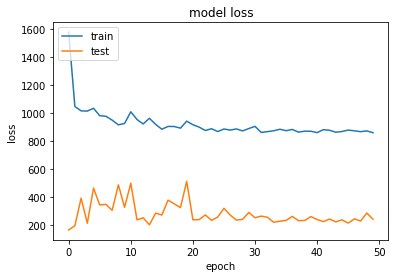

In [15]:
#create a graph called stats.png
plt.tight_layout()
fig1 = plt.gcf()
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
fig1.savefig('stats.png', dpi=100)

In [16]:
#submit predictions fo test
def submit(model, test):
  pred=model.predict(x)